### training cost calculations

In [ ]:
len(df.image_id.unique())/32

batches=200 # 6400 images w. batch size of 32
seconds_per_batch = 10

iterations = 5
parameters_space = 10

parameters_space*iterations*batches*seconds_per_batch/3600

---
# 

In [2]:
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm

DATA_PATH = "../../data/private/"

# file received from Marjolijn on 12.11.2024 
f = DATA_PATH+"ExportJSON_Sceneherkenning1_20112024-_20241120084401(1).json"

with open(f) as handle:
    j = json.load(handle)

## export contents

- info: basic info about export
- licenses: useless
- object_labels: empty
- image_labels: the "vocabulary"; each entry containing a label, an ID, a source (the NMVW thesaurus) and a parent ID 
- images: image record, incl handle URL  
- image_annotations: links between image_labels records and images records
- object_annotations: empty

In [4]:
voc = pd.DataFrame.from_records(j["image_labels"])#.set_index("id")

anns = pd.DataFrame.from_records(j["image_annotations"])


voc2 = pd.merge(voc, voc[["id", "name"]],
         left_on="parent_id",
         right_on="id",
        suffixes=("", "_parent")).set_index("id")

df = pd.merge(anns, voc2[["name", "parent_id", "name_parent"]],
         left_on="image_label_id",
         right_on="id")

# plt.plot(
#     list(df.name.
#      value_counts().
#      value_counts().
#      sort_index().values),
#     ".")

# plt.plot(
#     list(df.name.value_counts().sort_index().index),
#     list(df.name.value_counts().sort_index().values),
#     ".")


In [5]:
# basic stats

print(f"number of images:\t {len(df.image_id.unique())}")
print(f"number of annotations:\t {len(df)}")

number of images:	 3799
number of annotations:	 9704


---
# pure label distributions

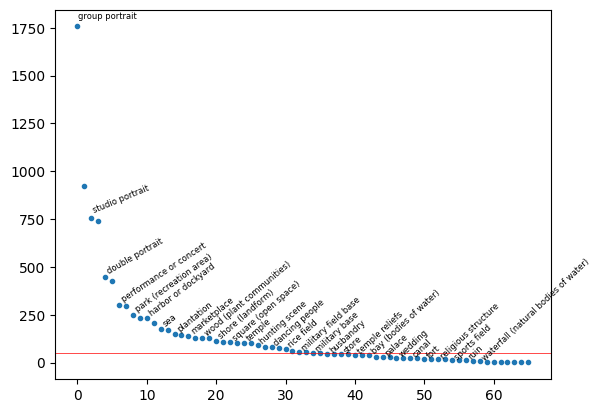

In [6]:
label_counts = df.name.value_counts()
plt.plot(
    list(label_counts.values),
    ".")
plt.axhline(50, c="red", lw=0.5)
# plt.annotate("frequency of 50", xytext=(0, 50), xy=(0, 0), arrowprops=dict(facecolor="black"))
# plt.yticks([50], ["50"])

for i in range(30):
    cur = label_counts.index[i*2]
    cur_y = label_counts.values[i*2]
    plt.annotate(cur, xy=(i*2+0.1, cur_y+cur_y**0.5), rotation=45*(1-1/(i+1)), fontsize=6)#, xy=(i*2, cur_y), arrowprops=dict(facecolor='black', shrink=0.05, width=0.001, headwidth=0.1))

---
# labels per image

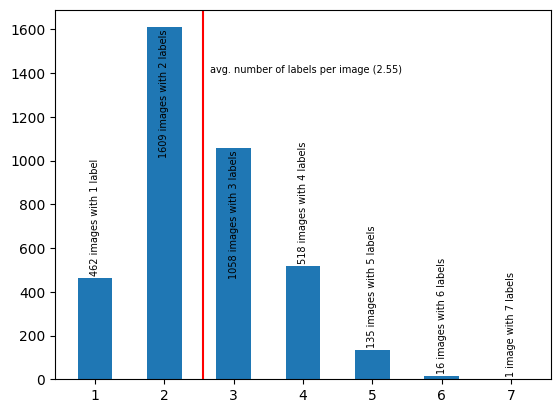

In [7]:
image_label_nums = df.image_id.value_counts().value_counts().sort_index()

# 1609 images have 2 labels
# 1058 images have 3 labels
# etc

plt.bar(list(image_label_nums.index),
    list(image_label_nums.values),
    0.5)

avg = sum(i*v for i, v in enumerate(image_label_nums, 1))/image_label_nums.sum()
plt.axvline(avg, c="r")
plt.annotate(f"avg. number of labels per image ({avg:.2f})", xy=(avg+0.1, 1400), fontsize=7)

for i, v in enumerate(image_label_nums):
    plt.annotate(f"{v} image{'s' if v > 1 else ''} with {i+1} label{'s' if i > 0 else ''}", 
                 xy=(i+1, v+(-10 if v > 1000 else 10)), 
                 rotation=90, fontsize=7, horizontalalignment="center", 
                 verticalalignment=("top" if v > 1000 else "bottom"))

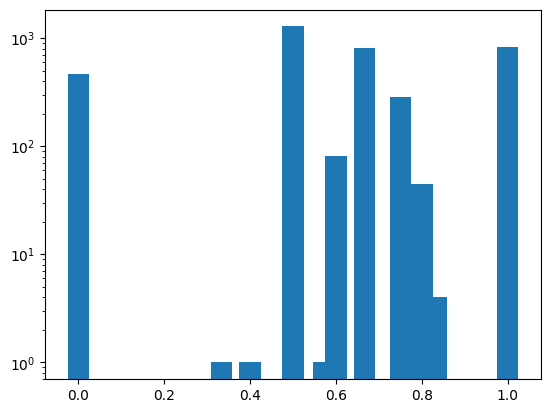

In [16]:
label_variances = df.groupby("image_id").name.apply(
    lambda sub: len(sub.unique())/len(sub) if len(sub) > 1 else 0.0
).value_counts().sort_index()

# 1.0 => all assigned labels for an image is different
# 0.5 => the number of total labels is 2 times the number of unique labels
# x -> 0. => there are many labels but all of them are the same (practically only possible if len(sub) <= 1)

plt.bar(list(label_variances.index), (list(label_variances.values)), width=0.05)

# plt.hist(list(label_variances))

plt.yscale("log")

In [104]:
label_variances.values.sum()
len(df.groupy("image_id")

9704

In [ ]:
from collections import Counter
def entropy(ls):
    ps = np.asarray(list(Counter(ls).values()))/len(ls)
    if len(ps) <= 1:
        return 0.0
    return - (ps*np.log2(ps)).sum()/np.log2(len(ls))

ents = df.groupby("image_id").name.apply(entropy)

ents.hist()#histtype="step")
# label_variances.hist(histtype="step")

In [ ]:
df.sample(1)

df[df.image_id == "1402235c-3cd0-43c5-ae31-8174b7d55863"]

---

In [ ]:
df.groupby("image_id").name.apply(len).sort_values()

In [ ]:
lists = df.groupby("image_id").name

cooc = [[lists.apply(lambda ls: int(a in ls and b in ls)).sum() 
         for b in sorted(df.name.unique())] for a in tqdm(sorted(df.name.unique()))]

In [ ]:
names = sorted(df.name.unique())
cooc = pd.DataFrame(np.zeros((len(names), len(names))), columns=names, index=names, dtype=int)


for iid, ls in tqdm(df.groupby("image_id").name):
    for a in ls:
        for b in ls:
            # print(a, b)
            if not a == b:
                cooc.loc[a, b] += 1

In [ ]:
cooc.sum(0).sort_values()

In [ ]:
cooc.loc["group portrait"].sort_values()

# df.name.apply(lambda x: x == "group portrait").sum()